# Machine Learning

In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures)
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

In [2]:
TEMP_PATH=os.path.join("temp")

## Trainingsdatensatz

In [3]:
train_df = pd.read_pickle(os.path.join(TEMP_PATH, "train2.pickle"))

In [4]:
train_df.shape

(32537, 20)

In [5]:
#train_df = train_df.sample(10000, random_state=42)

In [6]:
train_df.head()

,age,workclass,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,hours_category,age_category,gain_category,loss_category,native_region
0,39,state-gov,77516,bachelors,13,never-married,adm-clerical,not-in-family,white,male,2174,0,40,united-states,0,30,30,0,0,united-states
1,50,self-emp-not-inc,83311,bachelors,13,married-civ-spouse,exec-managerial,husband,white,male,0,0,13,united-states,0,10,40,0,0,united-states
2,38,private,215646,hs-grad,9,divorced,handlers-cleaners,not-in-family,white,male,0,0,40,united-states,0,30,30,0,0,united-states
3,53,private,234721,11th,7,married-civ-spouse,handlers-cleaners,husband,black,male,0,0,40,united-states,0,30,50,0,0,united-states
4,28,private,338409,bachelors,13,married-civ-spouse,prof-specialty,wife,black,female,0,0,40,cuba,0,30,20,0,0,mittelamerika


In [7]:
nums = ["age", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
cats = ["marital_status", "sex", "occupation"]
target = ["income"] #kann leider nicht genutzt werden, weil ravel damit nicht kann

## Testdatensatz

In [8]:
test_df = pd.read_pickle(os.path.join(TEMP_PATH, "test.pickle"))

In [9]:
test_df.shape

(16281, 15)

In [10]:
test_df = test_df.drop_duplicates()
test_df.shape

(16276, 15)

In [11]:
#umwandeln von income in eine binäre numerische Variable, <=50 wird 0, >50 wird 1...
test_df['income'] = test_df['income'].replace({"<=50k.": 0, ">50k.": 1})

In [12]:
#missings und zusammenfassen von occupation
# ? durch 'Other-service' ersetzen
test_df['occupation'] = test_df['occupation'].replace('?', 'other-service')

#'Armed-Forces', 'Protective-serv' und 'Priv-house-serv' durch 'protect-priv-serv' ersetzen
test_df['occupation'] = test_df['occupation'].replace(['armed-Forces', 'protective-serv', 'priv-house-serv'], 'protect-priv-serv')

## Pipelines

gehen die anderen Umwandlungen oben auch in der Pipeline??
<br>nochmal ganz ohne Poly testen??
<br>Features strenger auswählen besonders bei der logit? 
<br>ohne Pipeline beim Tree?? Random Forest noch??

In [13]:
num_pipeline = Pipeline(
    [
        ("pol", PolynomialFeatures(degree=2, interaction_only=True)),
        ("std_scaler", StandardScaler()),
    ]
)

In [14]:
cat_pipeline = Pipeline(
    [
        ("one_hot", OneHotEncoder()),
    ]
)

In [15]:
transform_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, nums),
        ("cat", cat_pipeline, cats),     
    ]
)

In [16]:
X_train = transform_pipeline.fit_transform(train_df)

In [17]:
#ravel wg Fehlermeldung, dass ein Array gefordert ist...
y_train = train_df["income"]
y_train = y_train.ravel()

In [18]:
X_test = transform_pipeline.transform(test_df)

In [19]:
y_test = test_df["income"]
y_test = y_test.ravel()

## Modelle

Zur Bewertung der Modelle wird der Accuracy Score, die Confusion Matrix und der Classification Report genutzt.


<img src="Confusion-Matrix.png" alt="drawing" style="width:500px;"/> 
Abbildung 1: Confusion Matrix 
<br>Quelle: Data Base Camp. Was ist die Konfusionsmatrix? Abgerufen am 02.05.2024 .

<img src="Confusion-Matrix2.png" alt="drawing" style="width:500px;"/> 
Abbildung 2: Confusion Matrix 
<br>Quelle: https://statologie.de/konfusionsmatrix-python/ Abgerufen am 02.05.2024 .

Dies ist die Graphik anhand derer die folgenden Werte interpretiert werden!

Wir befinden uns im Bereich des supervised learning und der binären Klassifikation. 
Es kommen verschiedene Algorithmen infrage.

In [20]:
#feature names für die spätere Auswertung der Koeffizienten, des Trees und der importance...
poly_feature_names = transform_pipeline.get_feature_names_out(input_features=train_df.columns)

### Logistic Regression Model

In [21]:
lr = LogisticRegression(random_state=42, max_iter=300)

In [22]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=300, random_state=42)

In [23]:
lr.score(X_train, y_train)

0.8486031287457356

In [24]:
lr.score(X_test, y_test)

0.8499016957483411

kein Overfitting

In [25]:
y_pred_lr=lr.predict(X_test)

In [26]:
print (confusion_matrix(y_test, y_pred_lr))

[[11562   868]
 [ 1575  2271]]


In [27]:
11562+868+1575+2271

16276

In [28]:
1575/16276

0.09676824772671418

In [29]:
868/16276

0.053330056524944706

In [30]:
(11562+2271)/16276

0.8499016957483411

In [31]:
11562/16276

0.7103710985500122

In [32]:
2271/16276

0.13953059719832883

9.7% der Fälle bekommen ein niedriges Einkommen vorhergesagt, obwohl sie ein hohes erreichen; 5.3% der Fälle bekommen ein hohes Einkommen vorhergesagt, obwohl sie ein niedriges erreichen...85% der Fälle werden korrekt vorhergesagt. Wobei 71% ein niedriges Einkommen vorhergesagt bekommen und 14% ein hohes (vgl trainingsdatensatz: 76% hoch, 24% niedrig)

In [33]:
print (classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     12430
           1       0.72      0.59      0.65      3846

    accuracy                           0.85     16276
   macro avg       0.80      0.76      0.78     16276
weighted avg       0.84      0.85      0.84     16276



Für niedriges Einkommen: in 88% der Fälle richtig (Precision), findet 93% der niedrigen Einkommen (Recall)
<br> für hohes Einkommen: in 72% der Fälle richtig, findet nur 59% der hohen Einkommen.

In [34]:
print(lr.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 300, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Versuche ein Hyperparameter Tuning vorzunehmen, waren nicht erfolgreich, da verschiedene Optionen immer mit der Warnung "max_iter reached" und "convergence warning" endeten...

In [35]:
#Koeffizienten
coefficients = lr.coef_[0]
for feature, coefficient in zip(poly_feature_names, coefficients):
    print(f"{feature}: {coefficient.round(3)}")

num__1: 0.0
num__age: 0.423
num__education_num: 0.988
num__capital_gain: 1.242
num__capital_loss: 0.255
num__hours_per_week: 0.322
num__age education_num: -0.25
num__age capital_gain: -0.319
num__age capital_loss: -0.094
num__age hours_per_week: 0.195
num__education_num capital_gain: 0.551
num__education_num capital_loss: 0.062
num__education_num hours_per_week: -0.161
num__capital_gain capital_loss: 0.0
num__capital_gain hours_per_week: 1.123
num__capital_loss hours_per_week: 0.045
cat__marital_status_divorced: -0.7
cat__marital_status_married-af-spouse: 1.681
cat__marital_status_married-civ-spouse: 1.442
cat__marital_status_married-spouse-absent: -0.72
cat__marital_status_never-married: -1.22
cat__marital_status_separated: -0.848
cat__marital_status_widowed: -0.692
cat__sex_female: -0.619
cat__sex_male: -0.437
cat__occupation_adm-clerical: 0.047
cat__occupation_armed-forces: -0.108
cat__occupation_craft-repair: -0.019
cat__occupation_exec-managerial: 0.739
cat__occupation_farming-fis

Text(0, 0.5, ' ')

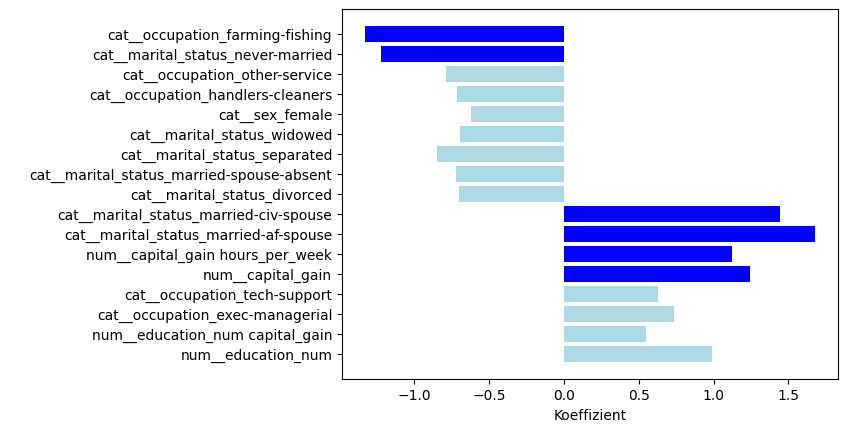

In [36]:
#dieser Code wurde mithilfe von ChatGPT entwickelt
# Funktion, um Koeffizienten in Gruppen einzuteilen
def group_coefficients(coefficients, feature_names):
    groups = {
        'between_0.5_and_1': [],
        'greater_than_1': [],
        'between_minus_0.5_and_minus_1': [],
        'less_than_minus_1': []
    }
    
    for feature, coefficient in zip(feature_names, coefficients):
        if coefficient > 1:
            groups['greater_than_1'].append((feature, coefficient))
        elif 0.5 <= coefficient <= 1:
            groups['between_0.5_and_1'].append((feature, coefficient))
        elif -1 <= coefficient < -0.5:
            groups['between_minus_0.5_and_minus_1'].append((feature, coefficient))
        elif coefficient < -1:
            groups['less_than_minus_1'].append((feature, coefficient))
    
    return groups

# Gruppiere die Koeffizienten
grouped_coefficients = group_coefficients(coefficients, poly_feature_names)

# Balkendiagramm erstellen
fig, ax = plt.subplots()

# Farben für die Balken
colors = {
    'between_0.5_and_1': 'lightblue',
    'greater_than_1': 'blue',
    'between_minus_0.5_and_minus_1': 'lightblue',
    'less_than_minus_1': 'blue'
}

# Durch die Gruppen iterieren und Balken hinzufügen
for group, values in grouped_coefficients.items():
    features, coeffs = zip(*values) if values else ([], [])
    ax.barh(features, coeffs, color=colors[group], label=group)

# Achsenbeschriftungen
ax.set_xlabel('Koeffizient')
ax.set_ylabel(' ')

# Anzeige der gruppierten Koeffizienten
#for group, values in grouped_coefficients.items():
    #print(f"{group}:")
    #for feature, coefficient in values:
        #print(f"  {feature}: {coefficient.round(3)}")

größten positiven Einfluss haben die Koeffizienten von capital_gain, marital_status_married, capital_gain*hours_per_week
<br>größten negativen Einfluss haben die Koeffizienten von marital_never_married und occupation_farmin-fishing

### Decision Tree

In [37]:
dt = DecisionTreeClassifier(random_state = 42, max_depth=3)

In [38]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [39]:
dt.score(X_train, y_train)

0.8438393213879584

In [40]:
dt.score(X_test, y_test)

0.8446792823789628

kein Overfitting! geringfügig schlechtere Accuracy als bei SVM und LR

In [41]:
y_pred_dt=dt.predict(X_test)

In [42]:
print (confusion_matrix(y_test, y_pred_dt))

[[11800   630]
 [ 1898  1948]]


In [43]:
1898/16276

0.11661341853035144

In [44]:
630/16276

0.038707299090685675

Hier bekommen 11.7% der Fälle ein niedriges Einkommen vorhergesagt, obwohl sie ein hohes erreichen; 3.9% der Fälle bekommen ein hohes Einkommen vorhergesagt, obwohl sie ein niedriges erreichen...

In [45]:
print (classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     12430
           1       0.76      0.51      0.61      3846

    accuracy                           0.84     16276
   macro avg       0.81      0.73      0.75     16276
weighted avg       0.84      0.84      0.83     16276



Für niedriges Einkommen: in 86% der Fälle richtig (Precision), findet 95% der niedrigen Einkommen (Recall)
<br> für hohes Einkommen: in 76% der Fälle richtig, findet nur 51% der hohen Einkommen.

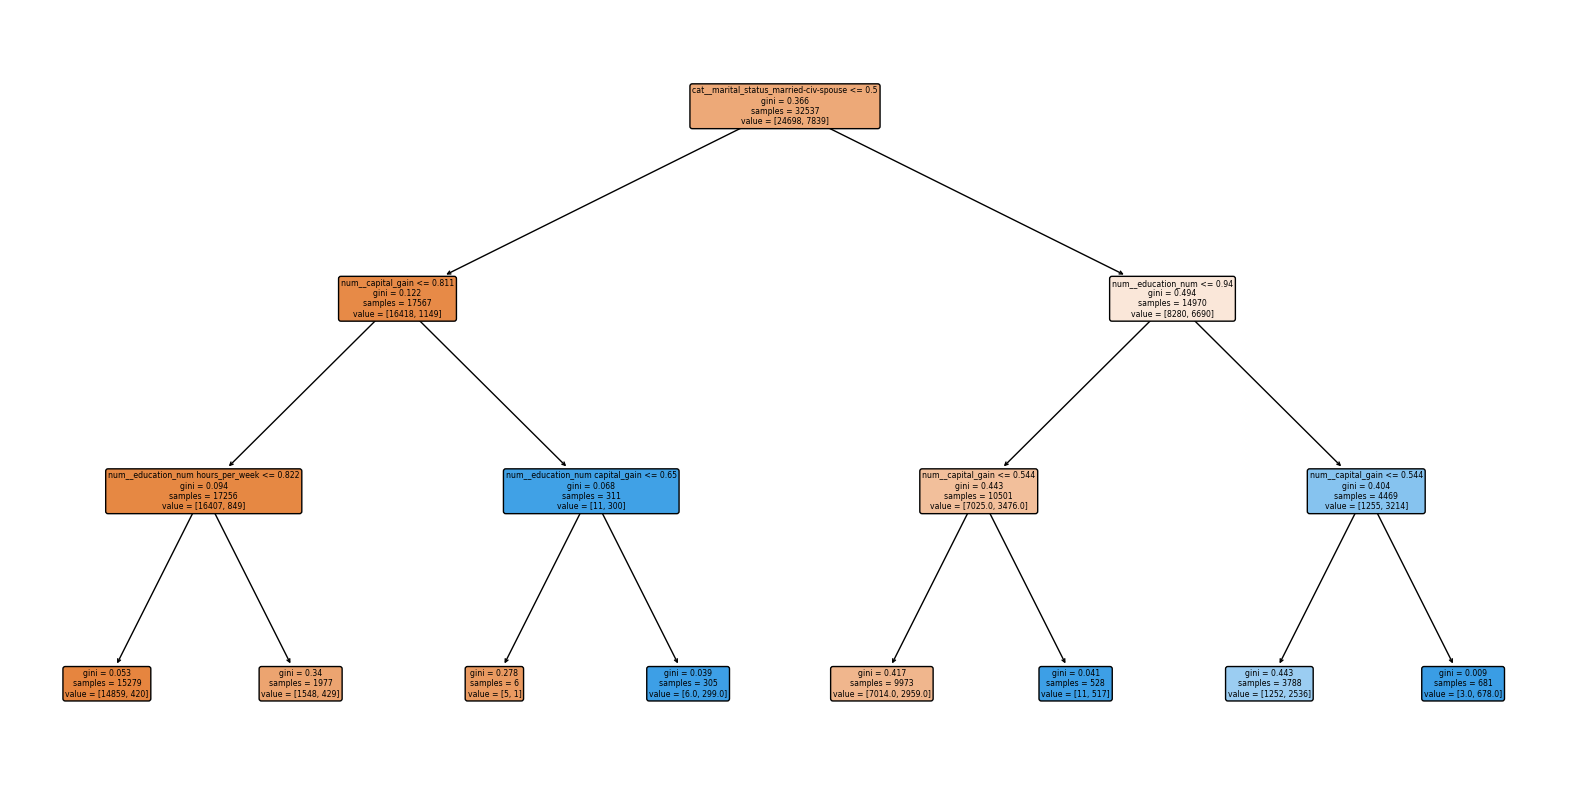

In [46]:
plt.figure(figsize=(20,10))
plot_tree(dt, max_depth=3, feature_names = poly_feature_names, filled=True, rounded=True)
plt.show()

Der DT nutzt die Features marital_status (civ-spouse), capital_gain, education_num, und Kombinationen aus education_num * hours_per_week, education_num*capital_gain für die Eingruppierung in die Einkommenskategorien.

In [47]:
print (dt.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


In [48]:
params_dt = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [10, 20, 30, 50],
    'min_samples_split': [50, 60, 80, 100, 150]
}

In [49]:
grid_dt = GridSearchCV(estimator=dt,
                      param_grid=params_dt,
                      scoring='accuracy',
                      cv=6,
                      n_jobs=1)

In [50]:
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=42),
             n_jobs=1,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [10, 20, 30, 50],
                         'min_samples_split': [50, 60, 80, 100, 150]},
             scoring='accuracy')

In [51]:
best_hyperparams = grid_dt.best_params_
print('best hyperparams:\n', best_hyperparams)

best hyperparams:
 {'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 50}


In [52]:
best_dt = grid_dt.best_estimator_

In [53]:
train_acc = best_dt.score(X_train, y_train)

In [54]:
print ('Train set accuracy of best model: {:.3f}'.format(train_acc))

Train set accuracy of best model: 0.860


In [55]:
test_acc = best_dt.score(X_test, y_test)

In [56]:
print ('Test set accuracy of best model: {:.3f}'.format(test_acc))

Test set accuracy of best model: 0.857


In [57]:
y_pred_best=best_dt.predict(X_test)

In [58]:
print (confusion_matrix(y_test, y_pred_best))

[[11766   664]
 [ 1668  2178]]


In [59]:
1668/16276

0.10248218235438683

In [60]:
664/16276

0.04079626443843696

In [61]:
11766/16276

0.7229048906365201

In [62]:
2178/16276

0.1338166625706562

10,2% bekommen ein niedriges Gehalt vorhergesagt, obwohl sie ein hohes erreichen werden. 4.1% bekommen ein hohes Gehalt vorhergesagt, obwohl sie ein niedriges erreichen werden. 72% bekommen korrekt ein niedriges Gehalt vorhergesagt und 13.4% korrekt ein hohes.

In [63]:
print (classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     12430
           1       0.77      0.57      0.65      3846

    accuracy                           0.86     16276
   macro avg       0.82      0.76      0.78     16276
weighted avg       0.85      0.86      0.85     16276



Für niedriges Einkommen: in 88% der Fälle richtig (Precision), findet 95% der niedrigen Einkommen (Recall)
<br> für hohes Einkommen: in 77% der Fälle richtig, findet nur 57% der hohen Einkommen.

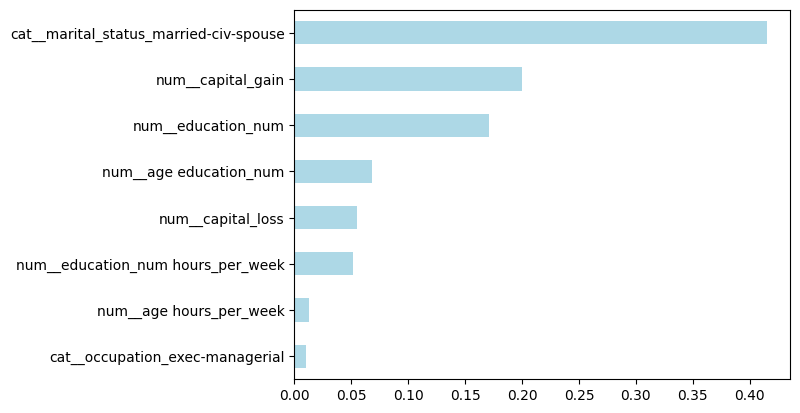

<Figure size 640x480 with 0 Axes>

In [64]:
#Feature importances anschauen
importances_dt = pd.Series(best_dt.feature_importances_, index=poly_feature_names)
sorted_importances_dt = importances_dt[importances_dt > 0.01].sort_values() 
sorted_importances_dt.plot(kind='barh', color="lightblue")
plt.show()
plt.tight_layout()